# Uber Trip Classification EDA and Modeling
Oleh : [enricoroselino](https://www.linkedin.com/in/enricoroselino/)

Dataset : [DTS Google Tensorflow 2 Demo day - GGU](https://www.kaggle.com/datasets/mnavas/taxi-routes-for-mexico-city-and-quito/code)

Tujuan :
* Membuat model yang dapat memprediksi kesalahan dalam pencatatan data perjalanan Uber.

Masalah :
* Tidak ada kolom label untuk menjadi target.
* Data tanggal tidak ada notasi AM / PM.

Landasan Teori :
* Batas kecepatan di kawasan perkotaan adalah 50 km/jam, kawasan permukiman adalah 30 km/jam, kawasan jalanan antar kota paling rendah adalah 60 km/jam dan kecepatan tol dalam kota paling cepat adalah 80 km/jam. ([Kumparan](https://kumparan.com/info-otomotif/batas-kecepatan-untuk-dalam-kota-begini-aturannya-1xvq35hLvXP/3), [Otomotif Kompas](https://otomotif.kompas.com/read/2022/06/20/191100215/batas-kecepatan-berkendara-di-jalan-tol-tidak-semua-sama))
* Waktu tunggu maksimal adalah 5 menit. ([therideshareguy](https://therideshareguy.com/uber-extends-wait-time/))


Label Feature Description :
* 0 = Trip not valid
* 1 = Trip valid

Kesimpulan :
* Dapat disimpulkan model **Deep Neural Network** lebih andal dengan **f1 score : 56.17%** pada data test dibandingkan dengan model lainnya. Model dapat diandalkan karena **lebih sedikit kesalahan** memprediksi perjalanan yang **sebenarnya valid dan tidak valid**.

* Sebagai alternatif, model **Random Forest Classifier** memiliki **f1 score : 54.26%** pada data test. Dengan pemodelan yang lebih ringkas namun performanya tidak jauh berbeda dengan Deep Neural Network.

## Import Libs

In [1]:
import os
import math
import re
import pandas as pd
from datetime import date, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from fast_ml.model_development import train_valid_test_split

%matplotlib inline
sns.set()

## Load Data

In [2]:
bog_path = os.path.join("dataset", "bog_clean.csv")
mex_path = os.path.join("dataset", "mex_clean.csv")
uio_path = os.path.join("dataset", "uio_clean.csv")

In [3]:
bog_df = pd.read_csv(bog_path)
mex_df = pd.read_csv(mex_path)
uio_df = pd.read_csv(uio_path)

## Explore Data

In [4]:
print(bog_df.shape)
print(mex_df.shape)
print(uio_df.shape)

(3063, 12)
(12694, 12)
(32366, 12)


In [5]:
# check bog unique value
for i in bog_df[["id", "vendor_id", "store_and_fwd_flag"]] :
    print(f"{i} : {bog_df[i].nunique()}")

id : 3063
vendor_id : 5
store_and_fwd_flag : 1


In [6]:
# check mex unique value
for i in mex_df[["id", "vendor_id", "store_and_fwd_flag"]] :
    print(f"{i} : {mex_df[i].nunique()}")

id : 12694
vendor_id : 7
store_and_fwd_flag : 1


In [7]:
# check uio unique value
for i in uio_df[["id", "vendor_id", "store_and_fwd_flag"]] :
    print(f"{i} : {uio_df[i].nunique()}")

id : 32366
vendor_id : 4
store_and_fwd_flag : 1


Dapat disimpulkan bahwa tidak ada dupilkat dari kolom `id`, `store_and_fwd_flag` hanya memiliki satu nilai unik dan `datetime` masih dalam tipe data objek pada setiap dataset

In [8]:
bog_df["country"] = "colombia"
mex_df["country"] = "mexico"
uio_df["country"] = "equador"

In [9]:
uber_df = pd.concat([bog_df, mex_df, uio_df], ignore_index=True)

In [10]:
uber_df = uber_df.drop(["id", "store_and_fwd_flag"], axis=1)

In [11]:
uber_df.describe().T

,count,mean,std,min,25%,50%,75%,max
pickup_longitude,48123.0,-8.365820e+01,9.327967e+00,-1.089851e+02,-99.055060,-78.499710,-78.477681,-7.382972e+01
pickup_latitude,48123.0,5.283597e+00,8.522385e+00,-3.454279e+00,-0.198366,-0.149986,19.281108,2.575296e+01
dropoff_longitude,48123.0,-8.365799e+01,9.326627e+00,-1.089874e+02,-99.040406,-78.498237,-78.479051,-7.361570e+01
dropoff_latitude,48123.0,5.282378e+00,8.524195e+00,-3.574739e+00,-0.201981,-0.151495,19.279311,2.578106e+01
trip_duration,48123.0,3.981179e+04,5.155872e+05,-3.887110e+05,497.000000,944.000000,1947.500000,7.002605e+07
dist_meters,48123.0,-3.774470e+04,1.695578e+07,-2.147484e+09,2032.000000,4133.000000,7880.000000,2.147484e+09
wait_sec,48123.0,1.519156e+07,6.005287e+08,0.000000e+00,101.000000,244.000000,534.000000,9.516306e+10


Terdapat nilai yang tidak realistis minimal dan maksimal pada `trip_duration`, `dist_meters`, dan `wait_sec	`

<a id="section-one"></a>
### Visualisasi Data

Membuat visualisasi untuk menjelaskan sebaran data yang tidak realistis / bermasalah

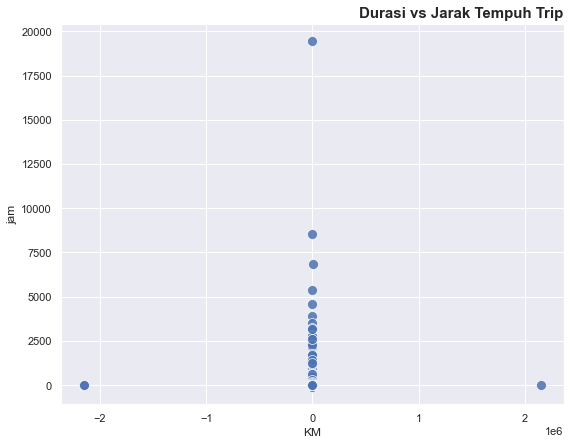

In [12]:
plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=uber_df,
    x=uber_df.dist_meters/1000,
    y=uber_df.trip_duration/3600,
    s=100,
    alpha=0.85
)

plt.title("Durasi vs Jarak Tempuh Trip",
    loc="right",
    fontweight="bold",
    size=15
)

plt.xlabel("KM")
plt.ylabel("jam")
plt.show()

Waktu dan jarak tempuh seharusnya tidak ada yang negatif, waktu tempuh paling lama adalah 1.94e+4 jam, serta jarak tempuh paling lama adalah 2.15e+6 KM.

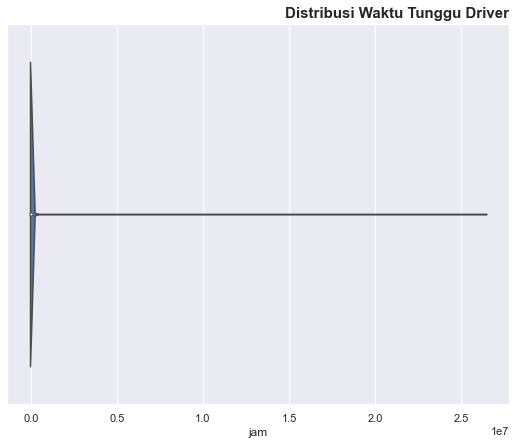

In [13]:
plt.figure(figsize=(9, 7))
sns.violinplot(x=uber_df["wait_sec"]/3600)

plt.title(
    "Distribusi Waktu Tunggu Driver",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("jam")
plt.show()

Waktu driver menunggu penumpang juga terlampau lama yaitu 2.6e+7 jam

In [14]:
# calculate speed in km/h
speed_kmph = (uber_df["dist_meters"] / 1000) / (uber_df["trip_duration"] / 3600)
speed_kmph.describe()

count    4.812300e+04
mean    -2.554891e+02
std      7.592147e+04
min     -1.498244e+07
25%      9.437383e+00
50%      1.642021e+01
75%      2.272778e+01
max      5.942307e+06
dtype: float64

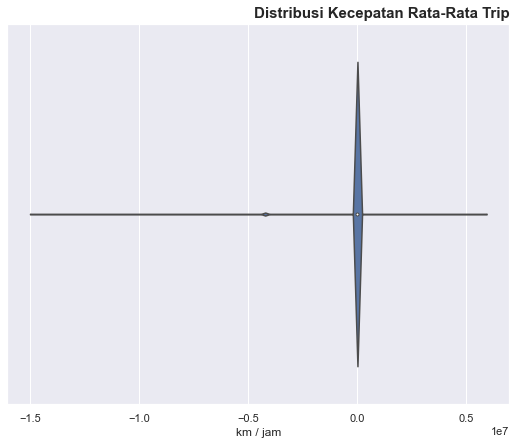

In [15]:
# plot kmph distribution
plt.figure(figsize=(9, 7))
sns.violinplot(x=speed_kmph)

plt.title(
    "Distribusi Kecepatan Rata-Rata Trip",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("km / jam")
plt.show()

Kecepatan kendaraan juga terdapat data negatif dan yang paling cepat adalah 5.94e+06

## CLEANING, PREPROCESSING, FEATURE ENGINEERING

### *_datetime
berapa lama waktu berlalu sejak waktu tersebut, umumnya digunakan reference date = hari ini. Namun, karena dataset ini merupakan dataset tahun 2014-2017, maka akan lebih relevan jika menggunakan reference date di sekitar tahun 2017. Dalam contoh ini, saya menggunakan tanggal 2017-12-01 sebagai reference date.

In [16]:
uber_df["pickup_datetime"] = pd.to_datetime(uber_df["pickup_datetime"], format='%Y/%m/%d')
uber_df["dropoff_datetime"] = pd.to_datetime(uber_df["dropoff_datetime"], format='%Y/%m/%d')

In [17]:
uber_df["mnths_since_pickup_date"] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - pd.to_datetime(uber_df["pickup_datetime"], format='%Y/%m/%d')) / np.timedelta64(1, 'M'))).astype(int)

In [18]:
uber_df["mnths_since_dropoff_date"] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - pd.to_datetime(uber_df["dropoff_datetime"], format='%Y/%m/%d')) / np.timedelta64(1, 'M'))).astype(int)

In [19]:
uber_df["mnths_since_pickup_date"].describe()

count    48123.000000
mean        10.212559
std          3.767937
min          4.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         35.000000
Name: mnths_since_pickup_date, dtype: float64

In [20]:
uber_df["mnths_since_dropoff_date"].describe()

count    48123.000000
mean        10.197930
std          3.765832
min          4.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         17.000000
Name: mnths_since_dropoff_date, dtype: float64

Menghitung lama perjalanan berdasarkan hari

In [21]:
uber_df["pickup_datetime"] = pd.to_datetime(uber_df["pickup_datetime"]).dt.date
uber_df["dropoff_datetime"] = pd.to_datetime(uber_df["dropoff_datetime"]).dt.date

In [22]:
def day_delta(df) :
    day = []
    for i in range(len(df)) :
        delta = (df.dropoff_datetime[i] - df.pickup_datetime[i]).days
        day.append(abs(int(delta)))
    return day

In [23]:
uber_df["day_delta"] = day_delta(uber_df)

In [24]:
uber_df = uber_df.drop(["pickup_datetime", "dropoff_datetime"], axis=1)

### est_meters
Membuat estimasi jarak menyetir sesungguhnya, bukan jarak antar 2 titik koordinat

In [25]:
def geodesic(p_lon, p_lat, d_lon, d_lat) :
    # calculate distance using geodesic method
    # COEF is a coeficient for calibrating the geodesic result to nearly matches OSRM driving distance
    # distance in meters
    COEF = 1.5165
    pickup = (p_lat, p_lon)
    dropoff = (d_lat, d_lon)
    result = distance(pickup, dropoff).km
    return result * COEF * 1000

def distance_estimator(df) :
    # calculate the duration then append to est_duration
    # using geodesic
    # name the estimated distance to est_meters
    distance = []
    for i in range(len(df)) :
        PICKUP_LONG = df.pickup_longitude[i]
        PICKUP_LAT = df.pickup_latitude[i]
        DROPOFF_LONG = df.dropoff_longitude[i]
        DROPOFF_LAT = df.dropoff_latitude[i]
        result = geodesic(PICKUP_LONG, PICKUP_LAT, DROPOFF_LONG, DROPOFF_LAT)
        distance.append(math.ceil(result))
    return distance

In [26]:
uber_df["est_meters"] = distance_estimator(uber_df)

### est_duration
Membuat estimasi durasi perjalanan sesungguhnya


In [27]:
def duration_estimator(df) :
    # rata-rata kecepatan 40 km/h
    time = []
    v = 40 * (1000/3600) # average speed in m/s
    for i in range(len(df)) :
        d = df.est_meters[i]
        t = d / v # time travel in seconds
        time.append(math.ceil(t))
    return time

In [28]:
uber_df["est_duration"] = duration_estimator(uber_df)

### avg_kmph
Membuat estimasi rata-rata kecepatan

In [29]:
def avg_kmph(df) :
    speed = []
    for i in range(len(df)) : 
        METERS = df.dist_meters[i]
        DURATION = df.trip_duration[i]
        result = (METERS / 1000) / (DURATION / 3600)
        speed.append(round(abs(result), 4))
    return speed

In [30]:
uber_df["avg_kmph"] = avg_kmph(uber_df)

### diff_meters & diff_duration
Menghitung perbedaan data estimasi dan tercatat

In [31]:
def diff(df) :
    meters = []
    duration = []
    for i in range(len(df)) : 
        EST_METERS = abs(df.est_meters[i])
        RECORDED_METERS = abs(df.dist_meters[i])
        EST_DURATION = abs(df.est_duration[i])
        RECORDED_DURATION = abs(df.trip_duration[i])
        result_meters = RECORDED_METERS - EST_METERS
        result_duration = RECORDED_DURATION - EST_DURATION
        meters.append(abs(result_meters))
        duration.append(abs(result_duration))
    return meters, duration

In [32]:
uber_df["diff_meters"], uber_df["diff_duration"] = diff(uber_df)

### vendor_id
Menetapkan tipe layanan uber

In [33]:
uber_df["vendor_id"].unique()

array(['Bogotá', 'Bogotá UberX', 'Bogota UberBlack', 'Bogotá UberVan',
       'Bogotá UberAngel', 'México DF Taxi de Sitio',
       'México DF Taxi Libre', 'México DF Radio Taxi', 'México DF UberX',
       'México DF UberXL', 'México DF UberSUV', 'México DF UberBlack',
       'Quito', 'Quito Cabify Lite', 'Quito Cabify Executive',
       'Quito UberX'], dtype=object)

Terdapat beberapa nama layanan yang tidak tersedia pada laman website uber akan dijadikan taxi dan sisanya akan disesuaikan dengan layanan ekivalennya

In [34]:
def services_extractor(df) :
    # extract services name from vendor_id and map the services based in 2022
    # some normal services is not available in 2022, it'll be taxi service instead
    # uberangel is exclusive to colombia, it'll be uberblack service instead
    # ubersuv will be uberxl
    SERVICE_NAME = re.compile(
        r"taxi|uberxl|uberx|uberblack|ubervan|uberangel|ubersuv"
    )
    df["vendor_id"] = df["vendor_id"].str.lower()
    service = []
    for i in range(len(df)) :
        extract = SERVICE_NAME.search(df.vendor_id[i])
        if extract != None :
            ext_group = extract.group()
            if (ext_group  == "ubervan") or (ext_group == "ubersuv"):
                service.append("uberxl")
            elif ext_group == "uberangel" :
                service.append("uberblack")
            else : 
                service.append(ext_group)
        else :
            service.append("taxi")
    return service

In [35]:
uber_df["service"] = services_extractor(uber_df)

In [36]:
uber_df["service"].unique()

array(['taxi', 'uberx', 'uberblack', 'uberxl'], dtype=object)

In [37]:
uber_df = uber_df.drop("vendor_id", axis=1)

## DEFINE TARGET VARIABLE / LABELING
Dalam project Uber Trip Classification bertujuan untuk melakukan prediksi terhadap kesalahan aplikasi saat menyimpan data perjalanan yang diakibatkan driver lupa mengakhiri perjalanan pada aplikasi, dan mengakibatkan kesalahan dalam penagihan harga kepada customer.

Variabel `est_meters`, `est_duration` dapat dijadikan pembanding kebenaran terhadap variabel `dist_meters` dan `trip_duration` yang terdapat kesalahan dalam peyimpanan.

Perbandingan menggunakan batas atas dan batas bawah yang terdiri dari toleransi perjalanan lebih lama atau lebih cepat yang diakibatkan oleh kecepatan mobil dan keadaan lalu lintas yang tidak menentu, batas waktu driver menunggu adalah 5 menit, minimal jarak perjalanan yang dianggap valid adalah 1 KM, serta perjalanan yang terhitung 1 hari mungkin valid apabila terjadi sekitar tengah malam, tetapi >= 2 hari sudah pasti tidak valid.

In [38]:
def labeler(df) :
    label = []
    DIST_MIN = 1000
    WT = 5 * 60
    for i in range(len(df)) :
        DLB = df.est_meters[i] * 0.8 # might be closer
        DHB = df.est_meters[i] * 1.5 # might be further
        TLB = df.est_duration[i] * 0.6667 # might be faster (~ 40 km/h - 60 km/h)
        THB = df.est_duration[i] * 4 * 1.5 # might be slower (~ 10 km/h - 40 km/h) and 50% longer
        DD = df.day_delta[i]
        if DD > 1 :
            label.append(0)
        elif (df.est_meters[i] < DIST_MIN) or (df.wait_sec[i] > WT): 
            label.append(0)
        elif (df.dist_meters[i] > DLB) and (df.dist_meters[i] < DHB) :
            if (df.trip_duration[i] > TLB) and (df.trip_duration[i] < THB) :
                label.append(1)
            else :
                label.append(0)
        else :
            label.append(0)
    return label

In [39]:
uber_df["label"] = labeler(uber_df)

In [40]:
for i in range(uber_df["label"].nunique()) :
    print("label {} : {}".format(i, list(uber_df["label"].values).count(i)))

label 0 : 35348
label 1 : 12775


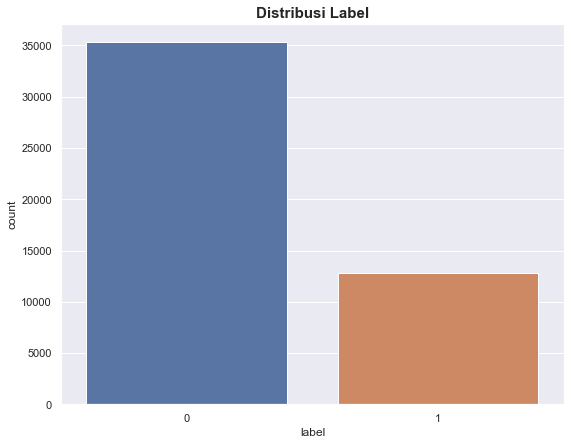

In [41]:
plt.figure(figsize=(9, 7))
sns.countplot(
    x= "label",
    data= uber_df
)

plt.title("Distribusi Label",
    loc="center",
    fontweight="bold",
    size=15
)

plt.show()

### Re-check Labeling Logic Reliability
Cek kembali apakah hasil dari labeling sudah sesuai dengan landasan teori

In [42]:
# load only True data
true_data = uber_df[(uber_df.label == 1)]

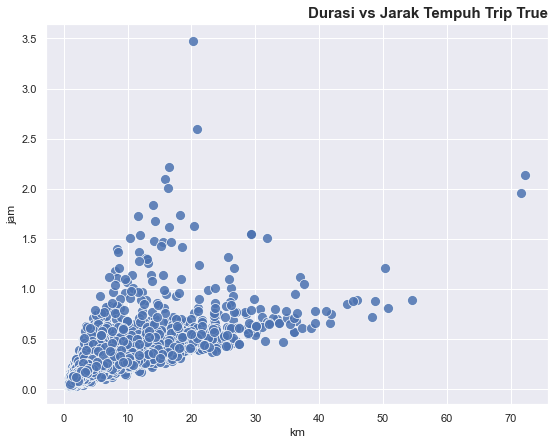

In [43]:
# plot dist_meter and trip_duratuion in hour
plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=true_data,
    x=true_data.dist_meters / 1000,
    y=true_data.trip_duration / 3600,
    s=100,
    alpha=0.85
)
plt.title("Durasi vs Jarak Tempuh Trip True",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("km")
plt.ylabel("jam")
plt.show()

In [44]:
true_data.avg_kmph.describe()

count    12775.000000
mean        22.965377
std          8.437277
min          5.537100
25%         17.152600
50%         21.559900
75%         27.313850
max         72.048300
Name: avg_kmph, dtype: float64

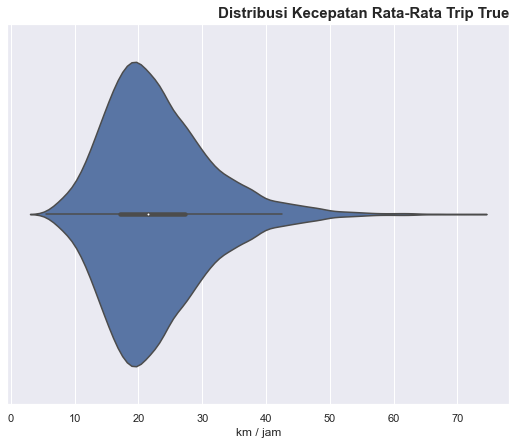

In [45]:
# plot kmph distribution
plt.figure(figsize=(9, 7))
sns.violinplot(x=true_data.avg_kmph)

plt.title(
    "Distribusi Kecepatan Rata-Rata Trip True",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("km / jam")
plt.show()

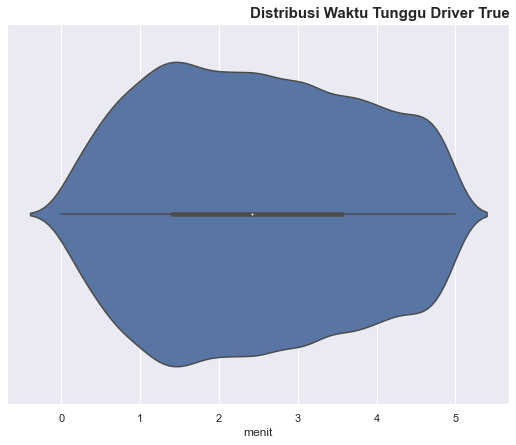

In [46]:
# plot wait_sec distribution
plt.figure(figsize=(9, 7))
sns.violinplot(x=true_data["wait_sec"] / 60)

plt.title(
    "Distribusi Waktu Tunggu Driver True",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("menit")
plt.show()

Data yang valid sudah memenuhi kriteria pada landasan teori seperti kecepatan maksimal adalah 72 km/jam dibawah batas maksimal kecepatan tol dalam kota dan waktu maksimal driver untuk menunggu tidak lebih dari 5 menit

### Missing Value Checking

In [47]:
check_missing = uber_df.isnull().sum() * 100 / uber_df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

Series([], dtype: float64)

Tidak ada data yang hilang / tidak sesuai jadi tidak perlu ditindaklanjuti

### Correlation Check

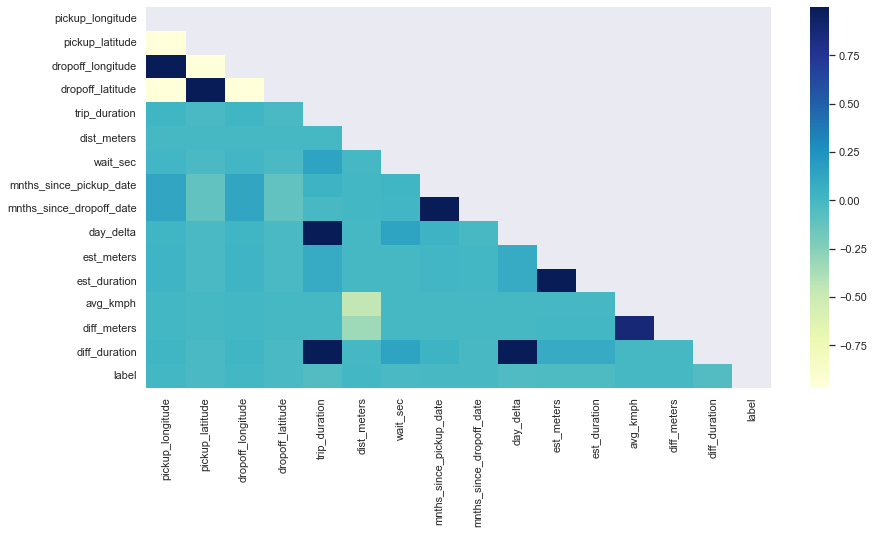

In [48]:
plt.figure(figsize=(14,7))
sns.heatmap(uber_df.corr(), cmap="YlGnBu", mask=np.triu(uber_df.corr()))
plt.show()

In [49]:
corr_matrix = uber_df.corr().abs()

In [50]:
to_pick_hicorr = corr_matrix.unstack()["label"].sort_values(kind="quicksort", ascending=False)

In [51]:
to_pick_hicorr

label                       1.000000
trip_duration               0.045576
diff_duration               0.045542
day_delta                   0.045187
est_duration                0.036731
est_meters                  0.036730
pickup_latitude             0.021895
dropoff_latitude            0.021803
wait_sec                    0.015208
mnths_since_pickup_date     0.009547
mnths_since_dropoff_date    0.007292
diff_meters                 0.004822
dropoff_longitude           0.004618
pickup_longitude            0.004577
avg_kmph                    0.004106
dist_meters                 0.001507
dtype: float64

In [52]:
high_corr= to_pick_hicorr[to_pick_hicorr > 0.005]

In [53]:
uber_df = pd.concat([uber_df[high_corr.index.tolist()], uber_df[["service", "country"]]], axis=1)

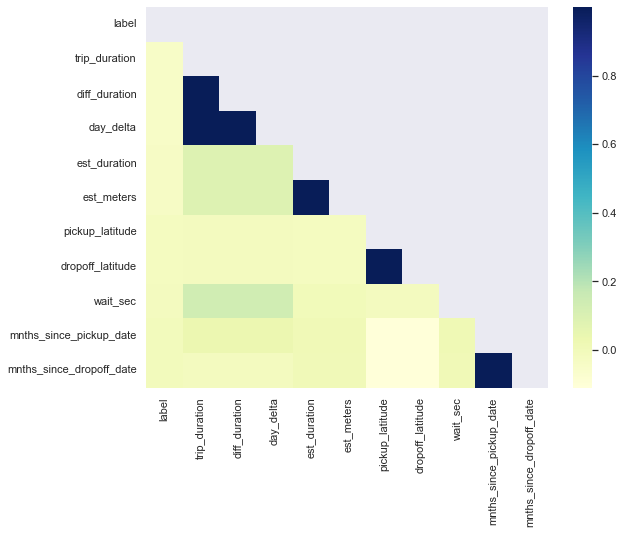

In [118]:
plt.figure(figsize=(9,7))
sns.heatmap(uber_df.corr(), cmap="YlGnBu", mask=np.triu(uber_df.corr()))
plt.show()

In [54]:
model_data = uber_df

## FEATURE SCALING AND TRANSFORMATION

### One Hot Encoding

In [55]:
categorical_cols = model_data.select_dtypes(include='object').columns.tolist()
ohe = pd.get_dummies(model_data[categorical_cols])

In [56]:
ohe.head()

,service_taxi,service_uberblack,service_uberx,service_uberxl,country_colombia,country_equador,country_mexico
0,1,0,0,0,1,0,0
1,1,0,0,0,1,0,0
2,1,0,0,0,1,0,0
3,1,0,0,0,1,0,0
4,1,0,0,0,1,0,0


In [57]:
model_data = pd.concat([model_data.drop(categorical_cols, axis=1), ohe], axis=1)

### Data Split

In [58]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(model_data, target = 'label', 
                                                                            train_size=0.6, valid_size=0.3, test_size=0.1, random_state=42)

### Standardization

In [59]:
numerical_cols = [col for col in X_train.columns.tolist() if col not in ohe.columns.tolist() + ['label']]

In [60]:
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_valid[numerical_cols] = scaler.fit_transform(X_valid[numerical_cols])
X_test[numerical_cols] = scaler.fit_transform(X_test[numerical_cols])

In [61]:
X_train.head(3)

,trip_duration,diff_duration,day_delta,est_duration,est_meters,pickup_latitude,dropoff_latitude,wait_sec,mnths_since_pickup_date,mnths_since_dropoff_date,service_taxi,service_uberblack,service_uberx,service_uberxl,country_colombia,country_equador,country_mexico
42639,-0.070325,-0.069921,-0.069926,-0.326669,-0.326419,-0.643270,-0.644029,-0.023050,1.270486,1.275845,1,0,0,0,0,1,0
8025,-0.070073,-0.069520,-0.069926,-0.427759,-0.428116,1.668732,1.667767,-0.023049,-1.117627,-1.114629,1,0,0,0,0,0,1
23787,-0.069950,-0.069238,-0.069926,-0.534465,-0.534766,-0.627815,-0.627580,-0.023049,0.209102,0.213412,1,0,0,0,0,1,0


### Class Balancing

In [62]:
oversample = SMOTETomek(random_state = 42, n_jobs= -1)
X_train, y_train = oversample.fit_resample(X_train, y_train)

## Machine Learning Model

In [63]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_curve, roc_auc_score

### Deep Neural Network

#### Model

In [64]:
# Set memory limiter for each GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [65]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    mode = "min",
    patience=3,
    verbose=1,
    baseline=None,
    restore_best_weights=True
)

csv_log = tf.keras.callbacks.CSVLogger(
    os.path.join("model", "history.csv"), 
    separator=",", 
    append=False
)

class mC(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get("val_accuracy") >= 99.6):
            self.model.stop_training = True
limiter = mC()

In [72]:
tf.keras.backend.clear_session()

In [73]:
KR = tf.keras.regularizers.L2(
    l2=0.0001
)

model = tf.keras.models.Sequential([
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(512, input_shape=(X_train.shape[1], ), activation="LeakyReLU", kernel_regularizer=KR),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="LeakyReLU", kernel_regularizer=KR),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="LeakyReLU", kernel_regularizer=KR),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="LeakyReLU", kernel_regularizer=KR),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=KR)
])

In [74]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics = ["accuracy"]
)

In [75]:
history = model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    batch_size=64,
    validation_batch_size=32,
    epochs=100, 
    verbose = 1,
    callbacks = [earlystop, csv_log, limiter]
)

Epoch 1/100
606/606 [==============================] - 20s 30ms/step - loss: 0.6768 - accuracy: 0.6421 - val_loss: 0.6509 - val_accuracy: 0.6152
Epoch 2/100
606/606 [==============================] - 18s 30ms/step - loss: 0.6051 - accuracy: 0.6978 - val_loss: 0.6039 - val_accuracy: 0.6339
Epoch 3/100
606/606 [==============================] - 18s 30ms/step - loss: 0.5840 - accuracy: 0.7059 - val_loss: 0.6179 - val_accuracy: 0.6255
Epoch 4/100
606/606 [==============================] - 18s 30ms/step - loss: 0.5713 - accuracy: 0.7073 - val_loss: 0.5761 - val_accuracy: 0.6496
Epoch 5/100
606/606 [==============================] - 18s 30ms/step - loss: 0.5631 - accuracy: 0.7074 - val_loss: 0.5868 - val_accuracy: 0.6441
Epoch 6/100
606/606 [==============================] - 18s 30ms/step - loss: 0.5552 - accuracy: 0.7119 - val_loss: 0.5954 - val_accuracy: 0.6324
Epoch 7/100
606/606 [==============================] - 18s 30ms/step - loss: 0.5521 - accuracy: 0.7113 - val_loss: 0.6164 - val_ac

#### Analyze Deep Neural Network

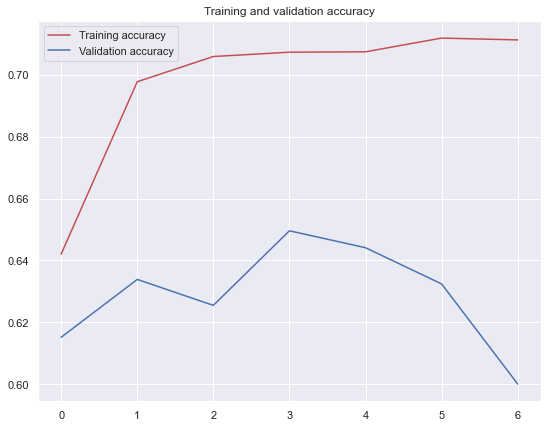

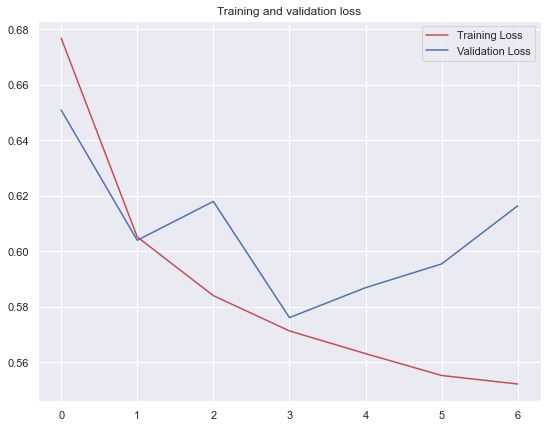

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(9, 7))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(9, 7))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [77]:
val_pred = model.predict(X_valid)
val_result = []
for pred in val_pred :
    if pred > 0.5 :
        val_result.append(1)
    else :
        val_result.append(0)

452/452 [==============================] - 3s 6ms/step


In [79]:
print(classification_report(list(y_valid), val_result, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.90      0.59      0.71     10687
           1       0.41      0.81      0.55      3750

    accuracy                           0.65     14437
   macro avg       0.66      0.70      0.63     14437
weighted avg       0.77      0.65      0.67     14437



In [81]:
f1 = f1_score(list(y_valid), val_result)
print(f1 * 100)

54.57484062135225


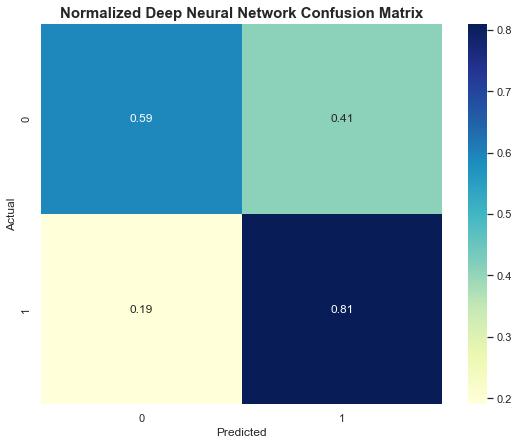

In [82]:
cm = confusion_matrix(list(y_valid), val_result)
cm_norm = np.round(cm / np.sum(cm, axis=1).reshape(-1,1), 2)
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm_norm, 
    cmap="YlGnBu", 
    annot=True
)
plt.title("Normalized Deep Neural Network Confusion Matrix",
    loc="center",
    fontweight="bold",
    size=15
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Random Forest

#### Model

In [83]:
rfc = RandomForestClassifier(max_depth=2, random_state=42, n_jobs=-1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=42)

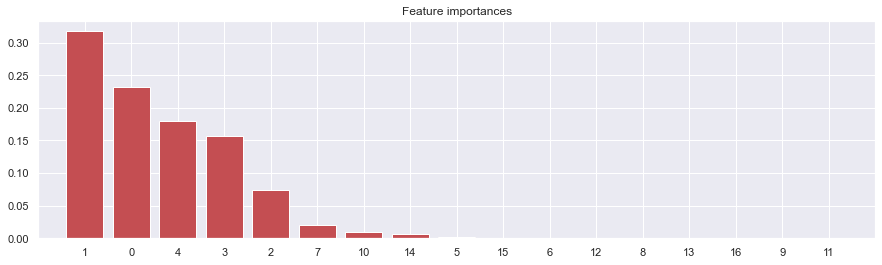

In [84]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(15,4))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
    color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

#### Analyze Random Forest (1)

In [85]:
y_pred_proba = rfc.predict_proba(X_valid)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_valid), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_valid.index

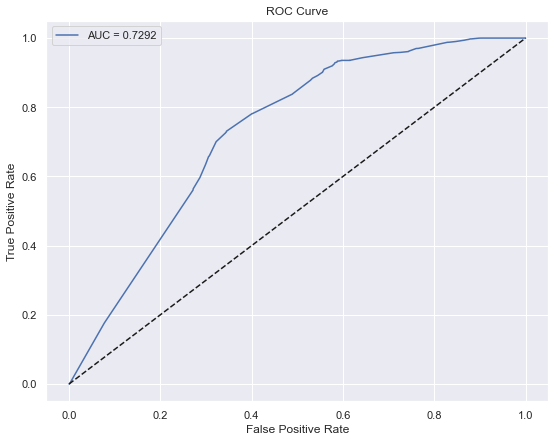

In [86]:
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.figure(figsize=(9, 7))
plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [87]:
df_actual_predicted = df_actual_predicted.sort_values('y_pred_proba')
df_actual_predicted = df_actual_predicted.reset_index()

df_actual_predicted['Cumulative N Population'] = df_actual_predicted.index + 1
df_actual_predicted['Cumulative N Bad'] = df_actual_predicted['y_actual'].cumsum()
df_actual_predicted['Cumulative N Good'] = df_actual_predicted['Cumulative N Population'] - df_actual_predicted['Cumulative N Bad']
df_actual_predicted['Cumulative Perc Population'] = df_actual_predicted['Cumulative N Population'] / df_actual_predicted.shape[0]
df_actual_predicted['Cumulative Perc Bad'] = df_actual_predicted['Cumulative N Bad'] / df_actual_predicted['y_actual'].sum()
df_actual_predicted['Cumulative Perc Good'] = df_actual_predicted['Cumulative N Good'] / (df_actual_predicted.shape[0] - df_actual_predicted['y_actual'].sum())

In [88]:
df_actual_predicted.head()

,index,y_actual,y_pred_proba,Cumulative N Population,Cumulative N Bad,Cumulative N Good,Cumulative Perc Population,Cumulative Perc Bad,Cumulative Perc Good
0,1871,0,0.029500,1,0,1,0.000069,0.0,0.000094
1,2616,0,0.029500,2,0,2,0.000139,0.0,0.000187
2,1503,0,0.029500,3,0,3,0.000208,0.0,0.000281
3,104,0,0.029500,4,0,4,0.000277,0.0,0.000374
4,12782,0,0.030685,5,0,5,0.000346,0.0,0.000468


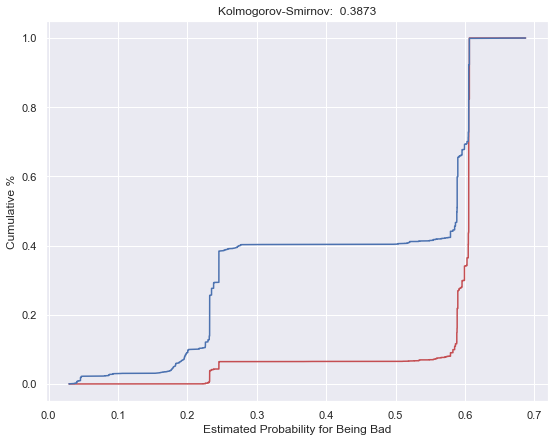

In [89]:
KS = max(df_actual_predicted['Cumulative Perc Good'] - df_actual_predicted['Cumulative Perc Bad'])

plt.figure(figsize=(9, 7))
plt.plot(df_actual_predicted['y_pred_proba'], df_actual_predicted['Cumulative Perc Bad'], color='r')
plt.plot(df_actual_predicted['y_pred_proba'], df_actual_predicted['Cumulative Perc Good'], color='b')
plt.xlabel('Estimated Probability for Being Bad')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov:  %0.4f' %KS)
plt.show()

#### Analyze Random Forest (2)

In [91]:
val_result = rfc.predict(X_valid)

In [92]:
print(classification_report(list(y_valid), val_result, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.95      0.40      0.57     10687
           1       0.35      0.93      0.51      3750

    accuracy                           0.54     14437
   macro avg       0.65      0.67      0.54     14437
weighted avg       0.79      0.54      0.55     14437



In [93]:
f1 = f1_score(list(y_valid), val_result)
print(f1 * 100)

51.45666691127907


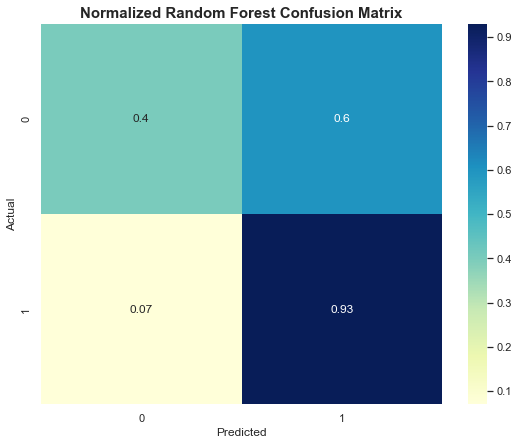

In [94]:
cm = confusion_matrix(list(y_valid), val_result)
cm_norm = np.round(cm / np.sum(cm, axis=1).reshape(-1,1), 2)
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm_norm, 
    cmap="YlGnBu", 
    annot=True
)
plt.title("Normalized Random Forest Confusion Matrix",
    loc="center",
    fontweight="bold",
    size=15
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### KNN

#### Model

In [95]:
def elbow() :
    error_rate = []
    for i in range(1,20):
        knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
        knn.fit(X_train,y_train)
        pred_i = knn.predict(X_valid)
        error_rate.append(np.mean(pred_i != y_valid))
    return error_rate

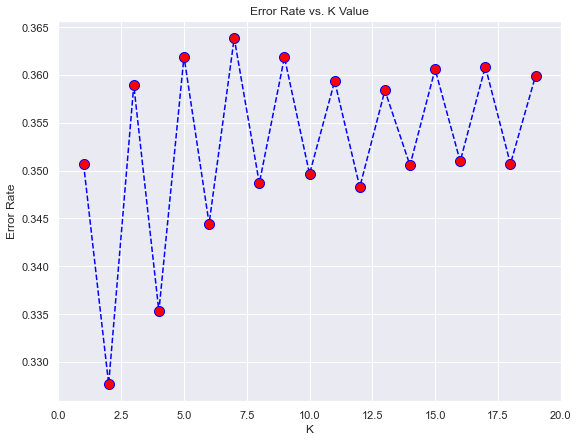

In [96]:
plt.figure(figsize=(9, 7))
plt.plot(range(1,20), elbow(), color="blue", linestyle="dashed", marker="o",
    markerfacecolor="red", markersize=10)
plt.title("Error Rate vs. K Value")
plt.xlabel("K")
plt.ylabel("Error Rate")
plt.xlim([0,20])
plt.show()

In [97]:
knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=2)

#### Analyze KNN

In [98]:
val_result = knn.predict(X_valid)

In [99]:
print(classification_report(list(y_valid), val_result, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77     10687
           1       0.39      0.47      0.43      3750

    accuracy                           0.67     14437
   macro avg       0.60      0.61      0.60     14437
weighted avg       0.69      0.67      0.68     14437



In [100]:
f1 = f1_score(list(y_valid), val_result)
print(f1 * 100)

42.800145085237574


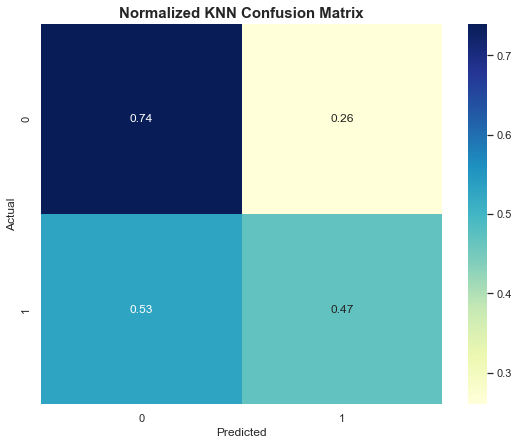

In [101]:
cm = confusion_matrix(list(y_valid), val_result)
cm_norm = np.round(cm / np.sum(cm, axis=1).reshape(-1,1), 2)
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm_norm, 
    cmap="YlGnBu", 
    annot=True
)
plt.title("Normalized KNN Confusion Matrix",
    loc="center",
    fontweight="bold",
    size=15
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Logistic Regression

#### Model

In [102]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

#### Analyze Logistic Regression

In [103]:
val_pred = logreg.predict(X_valid)
val_result = []
for pred in val_pred :
    if pred > 0.5 :
        val_result.append(1)
    else :
        val_result.append(0)

In [104]:
print(classification_report(list(y_valid), val_result, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.98      0.13      0.23     10687
           1       0.29      0.99      0.45      3750

    accuracy                           0.36     14437
   macro avg       0.64      0.56      0.34     14437
weighted avg       0.80      0.36      0.29     14437



In [105]:
f1 = f1_score(list(y_valid), val_result)
print(f1 * 100)

44.50017914725905


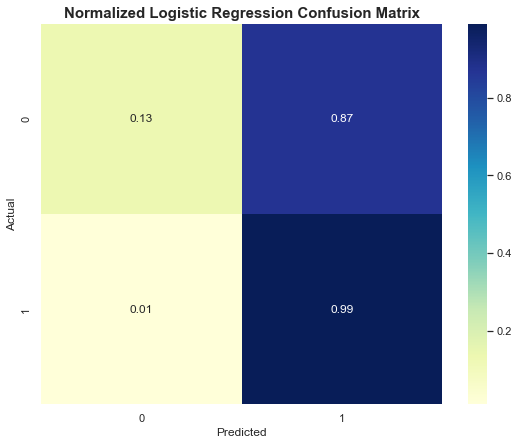

In [106]:
cm = confusion_matrix(list(y_valid), val_result)
cm_norm = np.round(cm / np.sum(cm, axis=1).reshape(-1,1), 2)
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm_norm, 
    cmap="YlGnBu", 
    annot=True
)
plt.title("Normalized Logistic Regression Confusion Matrix",
    loc="center",
    fontweight="bold",
    size=15
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## TEST DATA TIME!

In [107]:
DNN_test_predict = model.predict(X_test)
DNN_test_preds = []
for pred in DNN_test_predict :
    if pred > 0.5 :
        DNN_test_preds.append(1)
    else :
        DNN_test_preds.append(0)

151/151 [==============================] - 1s 5ms/step


In [108]:
RFC_test_preds = rfc.predict(X_test)

In [109]:
KNN_test_preds = knn.predict(X_test)

In [110]:
LOGREG_test_preds = logreg.predict(X_test)

In [111]:
print(f"f1 score Deep Neural Network : {round(f1_score(list(y_test), DNN_test_preds), 4) * 100}%")
print(f"f1 score Random Forest Classifier : {round(f1_score(list(y_test), RFC_test_preds), 4) * 100}%")
print(f"f1 score Logistic Regression : {round(f1_score(list(y_test), LOGREG_test_preds), 4) * 100}%")
print(f"f1 score K-Nearest Neighbours : {round(f1_score(list(y_test), KNN_test_preds), 4) * 100}%")

f1 score Deep Neural Network : 56.169999999999995%
f1 score Random Forest Classifier : 54.26%
f1 score Logistic Regression : 46.339999999999996%
f1 score K-Nearest Neighbours : 44.190000000000005%


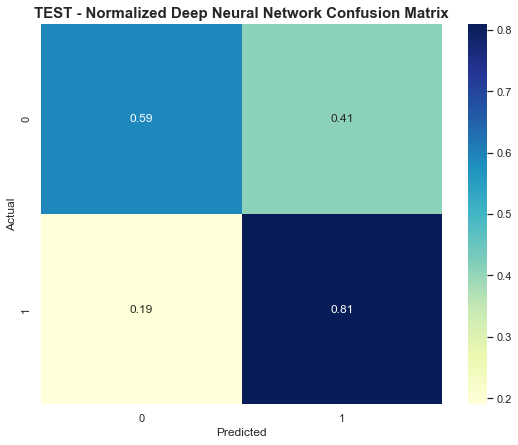

In [112]:
cm = confusion_matrix(list(y_test), DNN_test_preds)
cm_norm = np.round(cm / np.sum(cm, axis=1).reshape(-1,1), 2)
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm_norm, 
    cmap="YlGnBu", 
    annot=True
)
plt.title("TEST - Normalized Deep Neural Network Confusion Matrix",
    loc="center",
    fontweight="bold",
    size=15
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

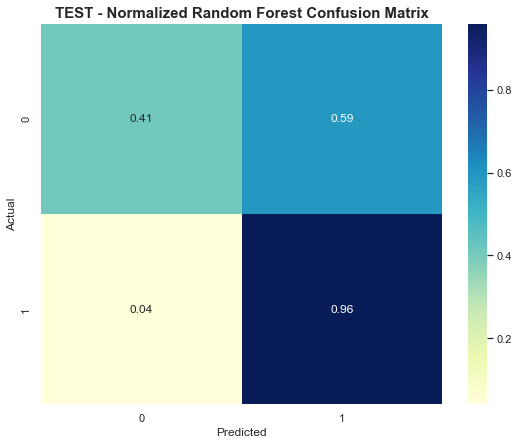

In [113]:
cm = confusion_matrix(list(y_test), RFC_test_preds)
cm_norm = np.round(cm / np.sum(cm, axis=1).reshape(-1,1), 2)
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm_norm, 
    cmap="YlGnBu", 
    annot=True
)
plt.title("TEST - Normalized Random Forest Confusion Matrix",
    loc="center",
    fontweight="bold",
    size=15
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

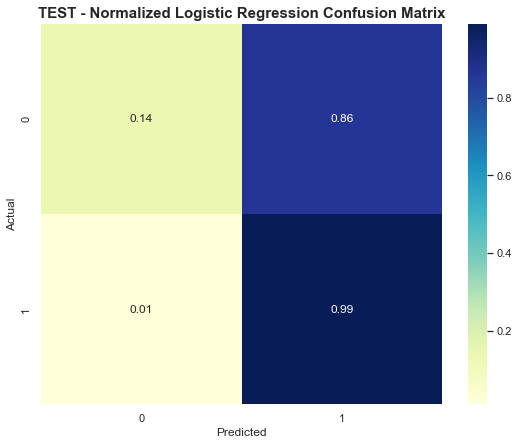

In [114]:
cm = confusion_matrix(list(y_test), LOGREG_test_preds)
cm_norm = np.round(cm / np.sum(cm, axis=1).reshape(-1,1), 2)
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm_norm, 
    cmap="YlGnBu", 
    annot=True
)
plt.title("TEST - Normalized Logistic Regression Confusion Matrix",
    loc="center",
    fontweight="bold",
    size=15
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

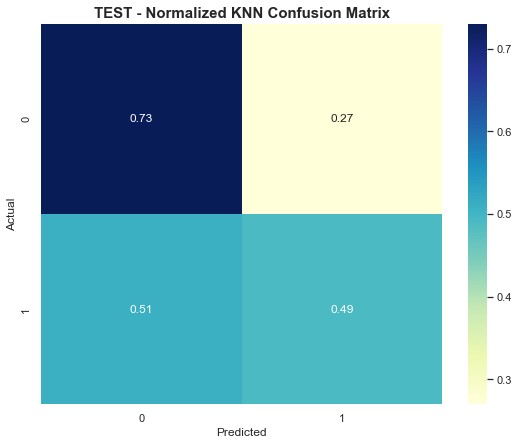

In [116]:
cm = confusion_matrix(list(y_test), KNN_test_preds)
cm_norm = np.round(cm / np.sum(cm, axis=1).reshape(-1,1), 2)
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm_norm, 
    cmap="YlGnBu", 
    annot=True
)
plt.title("TEST - Normalized KNN Confusion Matrix",
    loc="center",
    fontweight="bold",
    size=15
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Kesimpulan

* Dapat disimpulkan model **Deep Neural Network** lebih andal dengan **f1 score : 56.17%** pada data test dibandingkan dengan model lainnya. Model dapat diandalkan karena **lebih sedikit kesalahan** memprediksi perjalanan yang **sebenarnya valid dan tidak valid**.

* Sebagai alternatif, model **Random Forest Classifier** memiliki **f1 score : 54.26%** pada data test. Dengan pemodelan yang lebih ringkas namun performanya tidak jauh berbeda dengan Deep Neural Network.

In [119]:
!jupyter-nbconvert --to PDFviaHTML uber_trip_classification.ipynb

[NbConvertApp] Converting notebook uber_trip_classification.ipynb to PDFviaHTML
[NbConvertApp] Writing 1659625 bytes to uber_trip_classification.pdf
